# Deep learning framework example: Named Entity Recognition

This notebook demonstrates how to use the deeplearning API to train and test the model on the [CoNNL 2003 dataset](https://www.clips.uantwerpen.be/conll2003/ner/).  The task is to identify named entities (i.e. people, organizations etc).

**Important**: Please see the Movie Review notebook example in the `zensols.movie` API first, as it contains more explaination of how the framework is used.  The purpose of this notebook is to run the MNIST dataset and visualize the results.

In [1]:
# environemnt configuration and set up
class NotebookHarness(object):
    """Configure the Jupyter notebook environment and create model resources."""
    def __init__(self, app_root_dir: str = '..', deepnlp_path: str = '../../../src/python'):
        """Set up the interpreter environment so we can import local packages.
        
        :param app_root_dir: the application root directory
        :param deepnlp_path: the path to the DeepNLP source code
        """
        import sys
        from pathlib import Path
        self.app_root_dir = Path(app_root_dir)
        # add the example to the Python library path
        sys.path.append(str(self.app_root_dir / 'src'))
        # add the deepnlp path
        sys.path.append(deepnlp_path)
        from zensols.deeplearn import TorchConfig
        # reset random state for consistency before any other packages are imported
        TorchConfig.init()

    def __call__(self, cuda_device_index: int = None, temporary_dir_name: str = None):
        """Create and return an instance a :class:`.JupyterManager`.
        
        :param cuda_device_index: the CUDA (GPU) device to use
        :param temporary_dir_name: the temporary directory to use for temporary space and results
        """
        from zensols.deeplearn.cli import JupyterManager
        from ner import CliFactory
        factory_args = {'root_dir': self.app_root_dir}
        if temporary_dir_name is not None:
            factory_args['temporary_dir'] = self.app_root_dir / temporary_dir_name
        mng = JupyterManager(
            allocation_tracking='counts',
            cli_class=CliFactory,
            factory_args=factory_args,
            cli_args_fn=lambda model: ['-c', str(self.app_root_dir / 'models' / f'{model}.conf')])
        if cuda_device_index is not None:
            # tell which GPU to use
            mng.config('gpu_torch_config', cuda_device_index=cuda_device_index)
        return mng


harness = NotebookHarness()
mng = harness()
#mng = harness(1, 'target2')

## Print information about 

Use the factory to create the model executor.  The `write` method gives statistics on the data set that is configured on the executor.

In [2]:
from zensols.config import Writable
# set indention level for human readable (pretty print) output
Writable.WRITABLE_INDENT_SPACE = 2
facade = mng.create_facade('glove50')
facade.write()

2021-06-24 12:12:36,090 [zensols.deeplearn.model.facade] creating new executor
2021-06-24 12:12:36,983 [zensols.deepnlp.embed.wordtext] reading binary vector file: ../corpus/glove/bin/6B.50/vec
2021-06-24 12:12:37,359 [zensols.deepnlp.embed.wordtext] loaded 400000 vectors in 0s
2021-06-24 12:12:37,718 [zensols.deepnlp.embed.wordtext] prepared vectors in 0s
2021-06-24 12:12:37,719 [zensols.deepnlp.embed.domain] created tensor vectory matrix on use cuda: True, device: cuda:0
2021-06-24 12:12:40,213 [ner.corpus] reading ../corpus/connl-2003/train.txt


executor:
  model: NER: glove_50 
  feature splits:
    split stash splits:


2021-06-24 12:13:32,395 [ner.corpus] parsed 14041 sentences from train in 52s
2021-06-24 12:13:32,419 [ner.corpus] reading ../corpus/connl-2003/dev.txt
2021-06-24 12:13:45,413 [ner.corpus] parsed 3250 sentences from dev in 12s
2021-06-24 12:13:45,420 [ner.corpus] reading ../corpus/connl-2003/test.txt
2021-06-24 12:13:57,430 [ner.corpus] parsed 3453 sentences from test in 12s


        test: 3453 (16.6%)
        train: 14041 (67.7%)
        dev: 3250 (15.7%)
        total: 20744


2021-06-24 12:14:01,571 [zensols.deeplearn.batch.multi] sent_batch_stash: spawning work with chunk size 325 across 2 workers


    total this instance: 20744
    keys consistent: True
    delegate:
      key splits:
        test: 3453 (16.6%)
        train: 14041 (67.7%)
        dev: 3250 (15.7%)
      total: 20744
  batch splits:
    split stash splits:
        test: 108 (16.6%)
        train: 439 (67.6%)
        dev: 102 (15.7%)
        total: 649


2021-06-24 12:14:01,710 [zensols.deeplearn.batch.multi] using torch multiproc pool: <multiprocessing.pool.Pool state=RUN pool_size=2>
2021-06-24 12:17:51,201 [zensols.deeplearn.batch.multi] processed chunks in 3 minutes, 49s
2021-06-24 12:17:51,477 [zensols.multi.stash] completed work in BatchStash in 3 minutes, 49s
2021-06-24 12:17:51,604 [zensols.deeplearn.model.executor.status] created model on cpu with use cuda: True, device: cuda:0


    total this instance: 649
    keys consistent: True
    delegate:
      name: sent_batch_stash
      chunk_size: 0
      workers: 2
      batch_size: 32
      data_point_id_sets_path: ../data/batch/b32/keys.dat
      batch_limit: 9223372036854775807
      delegate_attr: True
      _has_data: True
      is_child: False
      _decoded_attributes: {'tags', 'ents', 'mask', 'syns', 'glove_50_embedding'}
      priming: False
  network settings:
    name: net_settings
    recurrent_crf_settings:
      name: recurrent_crf_settings
      dropout: 0.1
      network_type: lstm
      bidirectional: True
      hidden_size: 24
      num_layers: 1
      num_labels: 9
      decoder_settings:
        name: linear_settings
        middle_features:
        proportions: True
        repeats: 1
      score_reduction: sum
    mask_attribute: mask
    tensor_predictions: False
  model settings:
    name: model_settings
    path: ../target/model/glove_50_embedding
    learning_rate: 0.001
    epochs: 70
  

## Train and test the model

Train and test the model with the default (low) number of epochs to make sure everything is working.

2021-06-24 12:17:51,617 [zensols.deeplearn.model.executor.status] resetting executor
2021-06-24 12:17:51,619 [zensols.deeplearn.model.facade] training...
2021-06-24 12:17:51,627 [zensols.deeplearn.model.executor.status] batch iteration: gpu, limit: 9223372036854775807, caching: True, cached: 0
2021-06-24 12:17:51,627 [zensols.deeplearn.model.executor.status] preparing datasets using iteration: gpu
2021-06-24 12:17:51,628 [zensols.deeplearn.model.executor.status] using batch limit: 9223372036854775807 for train
2021-06-24 12:17:55,750 [zensols.deeplearn.model.executor.status] using batch limit: 9223372036854775807 for dev
2021-06-24 12:17:56,708 [zensols.deeplearn.model.executor.status] loaded 541 batches in 5s
2021-06-24 12:17:56,709 [zensols.deeplearn.model.executor.status] train/test sets: 439 102
2021-06-24 12:17:56,714 [zensols.deeplearn.model.executor.status] created model on cpu with use cuda: True, device: cuda:0
2021-06-24 12:17:56,755 [zensols.deeplearn.model.executor.status] 

Name: NER: glove_50 : 1
Run index: 2
Learning rate: 0.001
  train:
    started: 06/24/2021 12:17:56:758530
    ended: 06/24/2021 12:18:38:688451
    batches: 439
    ave data points per batch/total: 32.0/14041
    converged/epochs: 2/2
    min/ave/max loss: 1539.73608/3707.11770/7965.04328
    accuracy: nan (0/0)
    micro: F1: 0.000, precision: 0.000, recall: 0.000
    macro: F1: nan, precision: nan, recall: nan
    weighted: F1: 0.000, precision: 0.000, recall: 0.000
  validation:
    batches: 102
    ave data points per batch/total: 503.5/51362
    converged/epochs: 2/2
    min/ave/max loss: 1345.47699/3050.42521/9157.01098
    accuracy: 0.944 (48497/51362)
    micro: F1: 0.944, precision: 0.944, recall: 0.944
    macro: F1: 0.607, precision: 0.785, recall: 0.590
    weighted: F1: 0.936, precision: 0.940, recall: 0.944
  test:
    started: 06/24/2021 12:18:39:924039
    ended: 06/24/2021 12:18:41:338703
    batches: 108
    ave data points per batch/total: 430.0/46435
    converged/

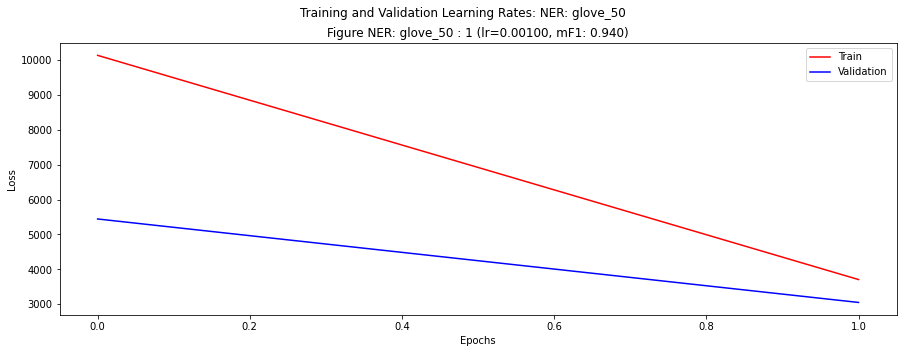

In [3]:
facade.epochs = 2
mng.run()

## Tune hyperparameters

Set model parameters to get a feel for where they need to be before changing features.  Start with Glove 50 dimensional word embeddings with a learning rate of 0.01 and 20 epochs.

2021-06-24 12:18:41,741 [zensols.deeplearn.model.executor.status] resetting executor
2021-06-24 12:18:41,742 [zensols.deeplearn.model.facade] training...
2021-06-24 12:18:41,744 [zensols.deeplearn.model.executor.status] batch iteration: gpu, limit: 9223372036854775807, caching: True, cached: 2
2021-06-24 12:18:41,744 [zensols.deeplearn.model.executor.status] train/test sets: 439 102
2021-06-24 12:18:41,820 [zensols.deeplearn.model.executor.status] created model on cpu with use cuda: True, device: cuda:0
2021-06-24 12:18:41,858 [zensols.deeplearn.model.executor.status] training model <class 'zensols.deepnlp.layer.embrecurcrf.EmbeddedRecurrentCRF'> on cuda:0 for 20 epochs using learning rate 0.01
tr:248.059|va min:1055.598|va:1292.116|lr:0.001 /\: 100%|███████████████████████████████| 20/20 [06:54<00:00, 20.63s/it]2021-06-24 12:25:36,688 [zensols.deeplearn.model.executor.status] epoch threshold reached at 20
2021-06-24 12:25:36,689 [zensols.deeplearn.model.executor.status] final minimum 

Name: NER: glove_50 : 1
Run index: 2
Learning rate: 0.01
  train:
    started: 06/24/2021 12:18:41:860946
    ended: 06/24/2021 12:25:36:689753
    batches: 439
    ave data points per batch/total: 32.0/14041
    converged/epochs: 20/20
    min/ave/max loss: 32.93118/248.05867/1099.83197
    accuracy: nan (0/0)
    micro: F1: 0.000, precision: 0.000, recall: 0.000
    macro: F1: nan, precision: nan, recall: nan
    weighted: F1: 0.000, precision: 0.000, recall: 0.000
  validation:
    batches: 102
    ave data points per batch/total: 503.5/51362
    converged/epochs: 5/20
    min/ave/max loss: 300.67016/1055.59843/3338.76575
    accuracy: 0.976 (50105/51362)
    micro: F1: 0.976, precision: 0.976, recall: 0.976
    macro: F1: 0.866, precision: 0.890, recall: 0.847
    weighted: F1: 0.975, precision: 0.975, recall: 0.976
  test:
    started: 06/24/2021 12:25:37:334326
    ended: 06/24/2021 12:25:38:704540
    batches: 108
    ave data points per batch/total: 430.0/46435
    converged/ep

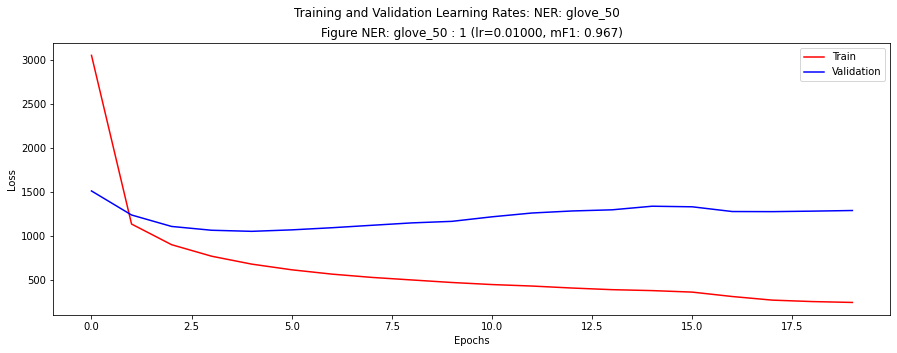

In [4]:
facade.learning_rate = 0.01
facade.epochs = 20
mng.run()

# Glove 300 embeddings

Next we use the same learning rate, but switch to the 300 dimension version of the embeddings.  The number of epochs is reduced because I have run the test before I know at what epoch the validation loss converges.  Since the model is saved only when the validation loss decreases, we early stop at 8 epochs.

2021-06-24 12:25:39,107 [zensols.deepnlp.embed.wordtext] reading binary vector file: ../corpus/glove/bin/6B.300/vec
2021-06-24 12:25:39,964 [zensols.deepnlp.embed.wordtext] loaded 400000 vectors in 0s
2021-06-24 12:25:40,688 [zensols.deepnlp.embed.wordtext] prepared vectors in 0s
2021-06-24 12:25:40,689 [zensols.deepnlp.embed.domain] created tensor vectory matrix on use cuda: True, device: cuda:0
2021-06-24 12:25:40,849 [zensols.deeplearn.model.facade] clearing
2021-06-24 12:25:41,119 [zensols.deeplearn.model.facade] creating new executor
2021-06-24 12:25:41,132 [zensols.deepnlp.embed.wordtext] reading binary vector file: ../corpus/glove/bin/6B.300/vec
2021-06-24 12:25:41,995 [zensols.deepnlp.embed.wordtext] loaded 400000 vectors in 0s
2021-06-24 12:25:42,722 [zensols.deepnlp.embed.wordtext] prepared vectors in 0s
2021-06-24 12:25:42,723 [zensols.deepnlp.embed.domain] created tensor vectory matrix on use cuda: True, device: cuda:0
2021-06-24 12:25:42,905 [zensols.deeplearn.model.execut

Name: NER: glove_50 : 1
Run index: 2
Learning rate: 0.01
  train:
    started: 06/24/2021 12:25:48:297131
    ended: 06/24/2021 12:28:44:450628
    batches: 439
    ave data points per batch/total: 32.0/14041
    converged/epochs: 8/8
    min/ave/max loss: 32.46873/278.06192/1428.36177
    accuracy: nan (0/0)
    micro: F1: 0.000, precision: 0.000, recall: 0.000
    macro: F1: nan, precision: nan, recall: nan
    weighted: F1: 0.000, precision: 0.000, recall: 0.000
  validation:
    batches: 102
    ave data points per batch/total: 503.5/51362
    converged/epochs: 3/8
    min/ave/max loss: 187.00793/1071.06605/3612.62720
    accuracy: 0.978 (50225/51362)
    micro: F1: 0.978, precision: 0.978, recall: 0.978
    macro: F1: 0.884, precision: 0.897, recall: 0.872
    weighted: F1: 0.978, precision: 0.978, recall: 0.978
  test:
    started: 06/24/2021 12:28:46:375733
    ended: 06/24/2021 12:28:47:927536
    batches: 108
    ave data points per batch/total: 430.0/46435
    converged/epoch

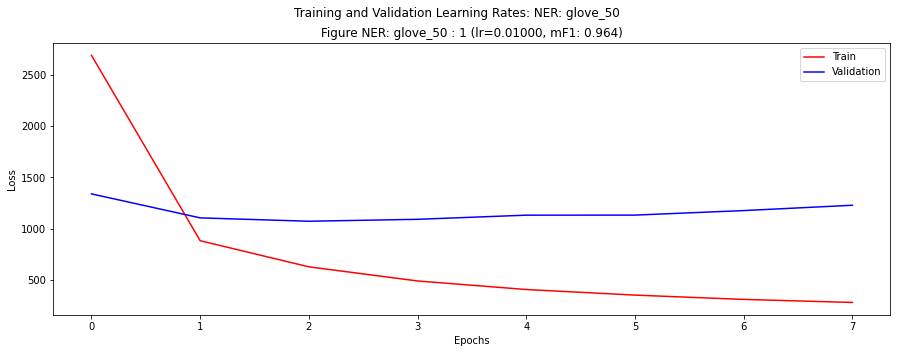

In [5]:
facade.epochs = 8
facade.embedding = 'glove_300_embedding'
mng.run()

# Word2vec Embeddings

Now we switch to the Google 300D word2vec pretrained vectors using 12 epochs, even though it has converged at 9 epochs previously.

2021-06-24 12:28:48,324 [zensols.deepnlp.embed.word2vec] reading binary vector file
2021-06-24 12:28:48,325 [zensols.deepnlp.embed.word2vec] loading keyed file: ../corpus/word2vec/GoogleNews-vectors-negative300.bin
2021-06-24 12:29:43,475 [zensols.deepnlp.embed.word2vec] loaded key model from /home/landes/view/nlp/deepnlp/example/ner/notebook/../corpus/word2vec/GoogleNews-vectors-negative300.bin in 55s
2021-06-24 12:29:43,476 [zensols.deepnlp.embed.word2vec] loaded word2vec model in 55s
2021-06-24 12:29:56,350 [zensols.deepnlp.embed.word2vec] created data structures in 12s
2021-06-24 12:29:58,713 [zensols.deepnlp.embed.domain] created tensor vectory matrix on use cuda: True, device: cuda:0
2021-06-24 12:29:59,914 [zensols.deeplearn.model.facade] clearing
2021-06-24 12:30:00,104 [zensols.deeplearn.model.facade] creating new executor
2021-06-24 12:30:00,117 [zensols.deepnlp.embed.word2vec] reading binary vector file
2021-06-24 12:30:00,117 [zensols.deepnlp.embed.word2vec] loading keyed f

Name: NER: glove_50 : 1
Run index: 2
Learning rate: 0.01
  train:
    started: 06/24/2021 12:31:22:558208
    ended: 06/24/2021 12:35:49:191491
    batches: 439
    ave data points per batch/total: 32.0/14041
    converged/epochs: 12/12
    min/ave/max loss: 13.17482/129.39439/615.11305
    accuracy: nan (0/0)
    micro: F1: 0.000, precision: 0.000, recall: 0.000
    macro: F1: nan, precision: nan, recall: nan
    weighted: F1: 0.000, precision: 0.000, recall: 0.000
  validation:
    batches: 102
    ave data points per batch/total: 503.5/51362
    converged/epochs: 4/12
    min/ave/max loss: 192.49699/916.00018/3143.01009
    accuracy: 0.980 (50337/51362)
    micro: F1: 0.980, precision: 0.980, recall: 0.980
    macro: F1: 0.889, precision: 0.902, recall: 0.879
    weighted: F1: 0.980, precision: 0.980, recall: 0.980
  test:
    started: 06/24/2021 12:35:56:151156
    ended: 06/24/2021 12:35:57:709512
    batches: 108
    ave data points per batch/total: 430.0/46435
    converged/epoc

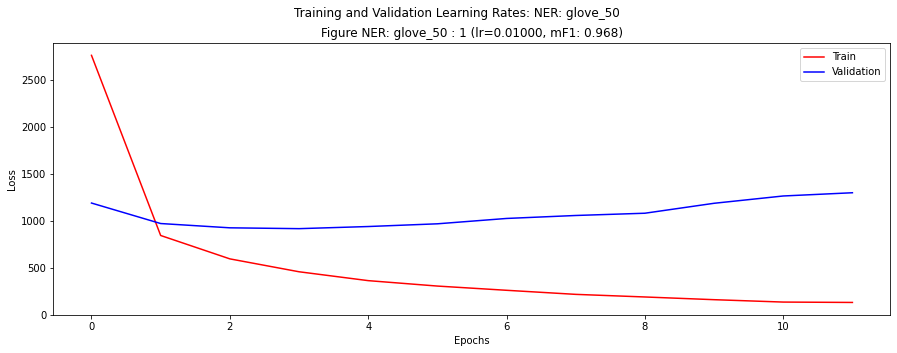

In [6]:
facade.epochs = 12
facade.embedding = 'word2vec_300_embedding'
mng.run()

# BERT Embeddings

Now we test with Bert context aware frozen (not trainable) embeddings using 10 epochs.  We must empty the `net_settings` attributes, which are the lingustic features, since Bert tokenizes using the word piece algorithm and the tensor shapes will not align.  We'll address this later.

total allocations: 20744
<class 'ner.corpus.NERFeatureSentence'>: 20744


2021-06-24 12:35:59,976 [zensols.deeplearn.model.facade] creating new executor
2021-06-24 12:36:02,148 [zensols.deeplearn.model.executor.status] resetting executor
2021-06-24 12:36:02,148 [zensols.deeplearn.model.facade] training...
2021-06-24 12:36:02,221 [zensols.deeplearn.model.executor.status] batch iteration: gpu, limit: 9223372036854775807, caching: True, cached: 0
2021-06-24 12:36:02,221 [zensols.deeplearn.model.executor.status] preparing datasets using iteration: gpu
2021-06-24 12:36:02,222 [zensols.deeplearn.model.executor.status] using batch limit: 9223372036854775807 for train
2021-06-24 12:36:03,268 [zensols.deeplearn.model.executor.status] using batch limit: 9223372036854775807 for dev
2021-06-24 12:36:03,513 [zensols.deeplearn.model.executor.status] loaded 541 batches in 1s
2021-06-24 12:36:03,514 [zensols.deeplearn.model.executor.status] train/test sets: 439 102
2021-06-24 12:36:03,856 [zensols.deeplearn.model.executor.status] created model on cpu with use cuda: True, de

Name: NER: transformer_trainable : 1
Run index: 2
Learning rate: 5e-05
  train:
    started: 06/24/2021 12:36:04:033780
    ended: 06/24/2021 13:36:22:709393
    batches: 439
    ave data points per batch/total: 463.8/203621
    converged/epochs: 4/4
    min/ave/max loss: 1.13798/2.41786/7.25515
    accuracy: 0.945 (192427/203621)
    micro: F1: 0.945, precision: 0.945, recall: 0.945
    macro: F1: 0.819, precision: 0.734, recall: 0.950
    weighted: F1: 0.949, precision: 0.959, recall: 0.945
  validation:
    batches: 102
    ave data points per batch/total: 503.5/51362
    converged/epochs: 1/4
    min/ave/max loss: 0.32051/2.26096/7.00217
    accuracy: 0.988 (50757/51362)
    micro: F1: 0.988, precision: 0.988, recall: 0.988
    macro: F1: 0.934, precision: 0.940, recall: 0.928
    weighted: F1: 0.988, precision: 0.988, recall: 0.988
  test:
    started: 06/24/2021 13:36:26:364171
    ended: 06/24/2021 13:37:42:069835
    batches: 108
    ave data points per batch/total: 430.0/46435

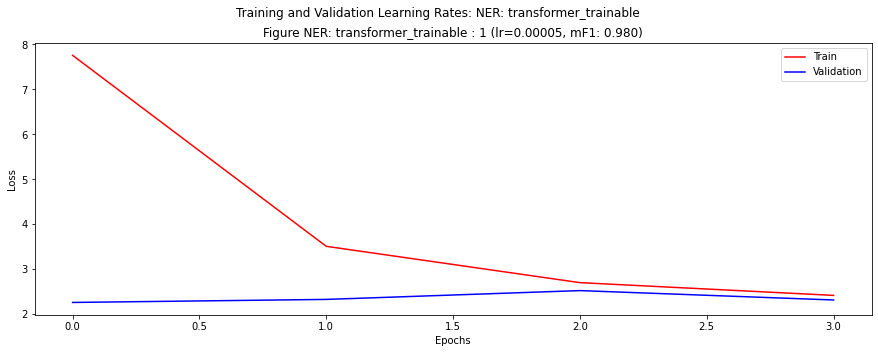

In [7]:
facade = mng.create_facade('transformer-trainable')
mng.run()

total allocations: 4436
<class 'zensols.deepnlp.transformer.domain.TokenizedDocument'>: 4436


2021-06-24 20:17:19,723 [zensols.deeplearn.model.facade] creating new executor
2021-06-24 20:17:21,346 [zensols.deeplearn.model.executor.status] resetting executor
2021-06-24 20:17:21,347 [zensols.deeplearn.model.facade] training...
2021-06-24 20:17:21,415 [zensols.deeplearn.model.executor.status] batch iteration: gpu, limit: 9223372036854775807, caching: True, cached: 0
2021-06-24 20:17:21,416 [zensols.deeplearn.model.executor.status] preparing datasets using iteration: gpu
2021-06-24 20:17:21,416 [zensols.deeplearn.model.executor.status] using batch limit: 9223372036854775807 for train
2021-06-24 20:17:22,419 [zensols.deeplearn.model.executor.status] using batch limit: 9223372036854775807 for dev
2021-06-24 20:17:22,652 [zensols.deeplearn.model.executor.status] loaded 541 batches in 1s
2021-06-24 20:17:22,653 [zensols.deeplearn.model.executor.status] train/test sets: 439 102
2021-06-24 20:17:22,889 [zensols.deeplearn.model.executor.status] created model on cpu with use cuda: True, de

Name: NER: transformer_trainable : 1
Run index: 2
Learning rate: 5e-05
    train:
        started: 06/24/2021 20:17:23:053116
        ended: 06/24/2021 21:33:00:985159
        batches: 439
        ave data points per batch/total: 463.8/203621
        converged/epochs: 5/5
        min/ave/max loss: 1.00413/2.11780/5.23317
        accuracy: 0.947 (192747/203621)
        micro: F1: 0.947, precision: 0.947, recall: 0.947
        macro: F1: 0.823, precision: 0.739, recall: 0.953
        weighted: F1: 0.950, precision: 0.960, recall: 0.947
    validation:
        batches: 102
        ave data points per batch/total: 503.5/51362
        converged/epochs: 2/5
        min/ave/max loss: 0.16924/2.22242/7.15541
        accuracy: 0.990 (50832/51362)
        micro: F1: 0.990, precision: 0.990, recall: 0.990
        macro: F1: 0.944, precision: 0.943, recall: 0.946
        weighted: F1: 0.990, precision: 0.990, recall: 0.990
    test:
        started: 06/24/2021 21:33:04:907322
        ended: 06/24/

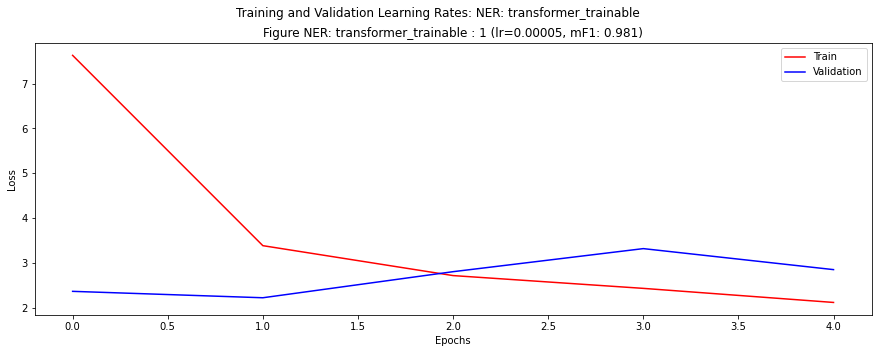

In [3]:
mng.clear()
facade = mng.create_facade('transformer-trainable')
facade.net_settings.add_attributes = ('syns_expander', 'tags_expander')
facade.epochs = 5
mng.run()

2021-06-24 17:49:08,419 [zensols.deeplearn.model.facade] creating new executor
2021-06-24 17:49:14,226 [zensols.deeplearn.model.executor.status] resetting executor
2021-06-24 17:49:14,227 [zensols.deeplearn.model.facade] training...
2021-06-24 17:49:14,338 [zensols.deeplearn.model.executor.status] batch iteration: gpu, limit: 9223372036854775807, caching: True, cached: 0
2021-06-24 17:49:14,339 [zensols.deeplearn.model.executor.status] preparing datasets using iteration: gpu
2021-06-24 17:49:14,340 [zensols.deeplearn.model.executor.status] using batch limit: 9223372036854775807 for train
2021-06-24 17:49:15,475 [zensols.deeplearn.model.executor.status] using batch limit: 9223372036854775807 for dev
2021-06-24 17:49:15,710 [zensols.deeplearn.model.executor.status] loaded 541 batches in 1s
2021-06-24 17:49:15,711 [zensols.deeplearn.model.executor.status] train/test sets: 439 102
2021-06-24 17:49:16,148 [zensols.deeplearn.model.executor.status] created model on cpu with use cuda: True, de

Name: NER: transformer_trainable : 1
Run index: 2
Learning rate: 5e-05
    train:
        started: 06/24/2021 17:49:16:404394
        ended: 06/24/2021 19:50:57:655531
        batches: 439
        ave data points per batch/total: 463.8/203621
        converged/epochs: 8/8
        min/ave/max loss: 2.00992/4.10208/8.98721
        accuracy: 0.929 (189153/203621)
        micro: F1: 0.929, precision: 0.929, recall: 0.929
        macro: F1: 0.759, precision: 0.685, recall: 0.872
        weighted: F1: 0.934, precision: 0.945, recall: 0.929
    validation:
        batches: 102
        ave data points per batch/total: 503.5/51362
        converged/epochs: 6/8
        min/ave/max loss: 2.85603/8.04778/15.54896
        accuracy: 0.952 (48876/51362)
        micro: F1: 0.952, precision: 0.952, recall: 0.952
        macro: F1: 0.793, precision: 0.816, recall: 0.774
        weighted: F1: 0.951, precision: 0.951, recall: 0.952
    test:
        started: 06/24/2021 19:51:02:420336
        ended: 06/24

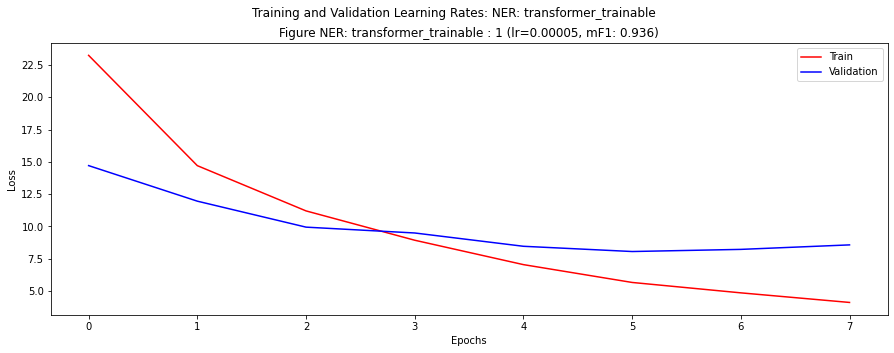

In [2]:
mng.clear()
mng.config('transformer_trainable_resource', model_id='roberta-base')
facade = mng.create_facade('transformer-trainable')
facade.epochs = 8
mng.run()